# Load dataset

In [1]:
from flwr_datasets.partitioner import IidPartitioner
from torch.utils.data import DataLoader
import datasets
import pandas as pd
import numpy as np
from PIL import Image


class ClinicPartitioner(IidPartitioner):
    """Partitioner for splitting MNIST into 5 centers."""

    def __init__(self):
        super().__init__(num_partitions=5)

    def load_partition(self, partition_id: int) -> datasets.Dataset:
        """
        Creates 5 partitions of the dataset:
            1. 0's and 1's
            2. 2's and 3's
            3. 4's and 5's
            4. 6's and 7's
            5. 8's and 9's
        """

        # Return the entire dataset if partition_id is -1
        if (partition_id == -1):
            return self.dataset

        df = pd.DataFrame(
            {
                "image": [np.array(img) for img in self.dataset["image"]],
                "label": self.dataset["label"],
            }
        )

        df1 = df[df["label"].isin([0, 1])]
        df2 = df[df["label"].isin([2, 3])]
        df3 = df[df["label"].isin([4, 5])]
        df4 = df[df["label"].isin([6, 7])]
        df5 = df[df["label"].isin([8, 9])]

        def convertPDtoDS(df):
            return datasets.Dataset.from_dict({
                "image": [Image.fromarray(np.array(img)) for img in df["image"]],
                "label": df["label"],
            })

        splitDataset = [
            convertPDtoDS(df1),
            convertPDtoDS(df2),
            convertPDtoDS(df3),
            convertPDtoDS(df4),
            convertPDtoDS(df5),
        ]

        return splitDataset[partition_id]


trainPartitioner = None
testPartitioner = None


def load_data(partition_id: int, split: int):
    """Load partition MNIST data."""
    # Only initialize `FederatedDataset` once
    global trainPartitioner, testPartitioner
    if trainPartitioner is None or testPartitioner is None:
        trainPartitioner = ClinicPartitioner()
        testPartitioner = ClinicPartitioner()
        ds = datasets.load_dataset(path="ylecun/mnist")
        ds = datasets.concatenate_datasets([ds["train"], ds["test"]])
        trainPartitioner.dataset = datasets.concatenate_datasets([ds.shard(5, i) for i in list(filter(lambda x: x != split, range(5)))])
        testPartitioner.dataset = ds.shard(5, split)
    partition_train = trainPartitioner.load_partition(partition_id)
    partition_test = testPartitioner.load_partition(partition_id)

    def apply_transforms(batch):
        """Apply transforms to the partition from FederatedDataset."""
        batch["image"] = [(np.array(img, dtype=np.float32) / 256).flatten() for img in batch["image"]] # Transform images to float and normalize
        return batch


    partition_train = partition_train.with_transform(apply_transforms)
    partition_test = partition_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train, batch_size=32, shuffle=True)
    testloader = DataLoader(partition_test, batch_size=32)
    return trainloader, testloader

c:\Users\Bruger\Desktop\Bachelor-Project---Federated-Incremental-Learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get model

In [2]:
from experiment3ERAGEM.task import get_net_train_test

Net, _, train, test = get_net_train_test(ILVariant="Task")

2025-06-08 14:39:25,253	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# Train and test model

In [ ]:
accuracies_global_fold = []
accuracies_01_fold = []
accuracies_23_fold = []
accuracies_45_fold = []
accuracies_67_fold = []
accuracies_89_fold = []
for i in range(5):
    net = Net()

    trainloader_global, testloader_global = load_data(-1, i)
    _, testloader01 = load_data(0, i)
    _, testloader23 = load_data(1, i)
    _, testloader45 = load_data(2, i)
    _, testloader67 = load_data(3, i)
    _, testloader89 = load_data(4, i)
    print(f"Loaded data for fold {i}")

    accuracies_global  = []
    accuracies_01 = []
    accuracies_23 = []
    accuracies_45 = []
    accuracies_67 = []
    accuracies_89 = []

    # Get initial performance
    loss, accuracy_global, _, _, _ = test(net, testloader_global, "cpu")
    loss01, accuracy01, _, _, _ = test(net, testloader01, "cpu")
    loss23, accuracy23, _, _, _ = test(net, testloader23, "cpu")
    loss45, accuracy45, _, _, _ = test(net, testloader45, "cpu")
    loss67, accuracy67, _, _, _ = test(net, testloader67, "cpu")
    loss89, accuracy89, _, _, _ = test(net, testloader89, "cpu")
    accuracies_global.append(accuracy_global)
    accuracies_01.append(accuracy01)
    accuracies_23.append(accuracy23)
    accuracies_45.append(accuracy45)
    accuracies_67.append(accuracy67)
    accuracies_89.append(accuracy89)

    epocs = 50
    for i in range(epocs):
        print(f"Epoch {i+1}/{epocs}")
        # Train the model
        train_loss = train(net, trainloader_global, None, "cpu")

        loss, accuracy_global, _, _, _ = test(net, testloader_global, "cpu")
        loss01, accuracy01, _, _, _ = test(net, testloader01, "cpu")
        loss23, accuracy23, _, _, _ = test(net, testloader23, "cpu")
        loss45, accuracy45, _, _, _ = test(net, testloader45, "cpu")
        loss67, accuracy67, _, _, _ = test(net, testloader67, "cpu")
        loss89, accuracy89, _, _, _ = test(net, testloader89, "cpu")
        print(f"Epoch {i+1}/{epocs}, train_loss: {train_loss:.4f}, test_accuracy: {accuracy_global:.4f}")
        accuracies_global.append(accuracy_global)
        accuracies_01.append(accuracy01)
        accuracies_23.append(accuracy23)
        accuracies_45.append(accuracy45)
        accuracies_67.append(accuracy67)
        accuracies_89.append(accuracy89)
    accuracies_global_fold.append(accuracies_global)
    accuracies_01_fold.append(accuracies_01)
    accuracies_23_fold.append(accuracies_23)
    accuracies_45_fold.append(accuracies_45)
    accuracies_67_fold.append(accuracies_67)
    accuracies_89_fold.append(accuracies_89)

In [ ]:
d_save = {
    "accuracies_global": accuracies_global_fold,
    "accuracies_01": accuracies_01_fold,
    "accuracies_23": accuracies_23_fold,
    "accuracies_45": accuracies_45_fold,
    "accuracies_67": accuracies_67_fold,
    "accuracies_89": accuracies_89_fold
}

import pickle
with open("accuracies_ML_task.pkl", "wb") as f:
    pickle.dump(d_save, f)



In [3]:
axis_font_size = 14
title_font_size = 16
fig_title_font_size = 18
legend_font_size = 14

In [4]:
import pickle

# Load the accuracies from the file
d_load = None
with open("accuracies_ML_task.pkl", "rb") as f:
    d_load = pickle.load(f)

acc_global = np.array(d_load["accuracies_global"])
acc_01 = np.array(d_load["accuracies_01"])
acc_23 = np.array(d_load["accuracies_23"])
acc_45 = np.array(d_load["accuracies_45"])
acc_67 = np.array(d_load["accuracies_67"])
acc_89 = np.array(d_load["accuracies_89"])

In [5]:
def get_mean_std(acc):
    """Get mean and std of the accuracies."""
    return np.mean(acc, axis=0), np.std(acc, axis=0)

mean_global, std_global = get_mean_std(acc_global)
mean_01, std_01 = get_mean_std(acc_01)
mean_23, std_23 = get_mean_std(acc_23)
mean_45, std_45 = get_mean_std(acc_45)
mean_67, std_67 = get_mean_std(acc_67)
mean_89, std_89 = get_mean_std(acc_89)

In [6]:
def print_final_mean_std(mean, std, label):
    """Print the final mean and std of the accuracies."""
    print("acctstd{" + f"{mean:.3f}" +"}{" + f"{std:.3f}" +"}")
    # print(f"{label} - Mean: {mean:.4f}, Std: {std:.4f}")

print_final_mean_std(mean_global[-1], std_global[-1], "Global")
print_final_mean_std(mean_01[-1], std_01[-1], "0's and 1's")
print_final_mean_std(mean_23[-1], std_23[-1], "2's and 3's")
print_final_mean_std(mean_45[-1], std_45[-1], "4's and 5's")
print_final_mean_std(mean_67[-1], std_67[-1], "6's and 7's")
print_final_mean_std(mean_89[-1], std_89[-1], "8's and 9's")

acctstd{0.994}{0.000}
acctstd{0.999}{0.000}
acctstd{0.982}{0.002}
acctstd{0.997}{0.001}
acctstd{0.998}{0.000}
acctstd{0.991}{0.001}


C:\Users\Bruger\AppData\Local\Temp\ipykernel_25740\1085315461.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax.legend(fontsize=legend_font_size, loc="lower right")


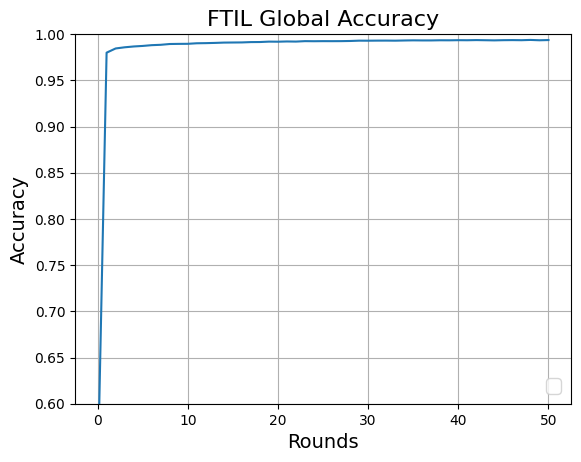

In [9]:
import matplotlib.pyplot as plt

class Plot:
    def __init__(self):
        self.fig, self.ax = plt.subplots()

    def plot_mean_std(self, mean_data: np.ndarray, std_data: np.ndarray, title: str = "", name: str = "", x_label: str = "Rounds", y_label: str = "Metric", show_end_value: bool = False, ylims = (0, 1)):
            rounds = np.arange(len(mean_data))

            self.ax.plot(rounds, mean_data, label=f"{name}")
            self.ax.fill_between(
                rounds,
                mean_data - std_data,
                mean_data + std_data,
                alpha=0.1,
                # label=f"{name} (Standard Deviation)",
            )

            self.ax.set_xlabel(x_label, fontsize=axis_font_size)
            self.ax.set_ylabel("Accuracy", fontsize=axis_font_size)
            self.ax.set_title(title, fontsize=title_font_size)
            self.ax.set_ylim(ylims)
            self.ax.grid()
            
            # Show last value of mean_data on the plot
            # if show_end_value:
            #     self.ax.text(
            #         rounds[-1] + 5,
            #         mean_data[-1],
            #         f"{mean_data[-1]:.3f}",
            #         fontsize=10,
            #         verticalalignment="bottom",
            #         horizontalalignment="right",
            #         color="black",
            #         bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
            #     )

            self.ax.legend(fontsize=legend_font_size, loc="lower right")             

            return self.fig, self.ax

p = Plot()

fig, ax = p.plot_mean_std(mean_global, std_global, title="FTIL Global Accuracy", show_end_value=True, ylims=(0.6, 1))

fig.savefig("exp3_ML_global_accuracy_task.svg", format="svg")

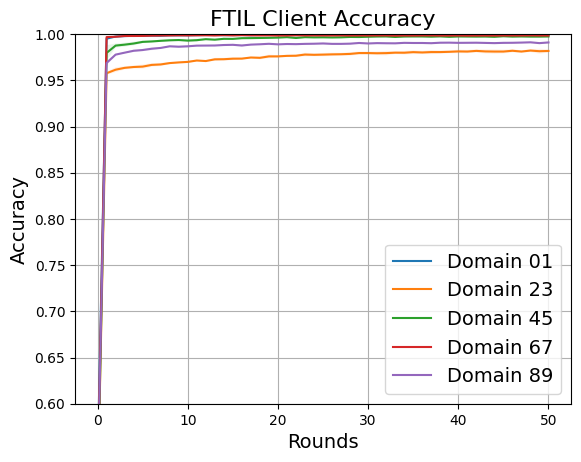

In [10]:
p = Plot()

p.plot_mean_std(mean_01, std_01, title="FTIL Client Accuracy", name="Domain 01")
p.plot_mean_std(mean_23, std_23, title="FTIL Client Accuracy", name="Domain 23")
p.plot_mean_std(mean_45, std_45, title="FTIL Client Accuracy", name="Domain 45")
p.plot_mean_std(mean_67, std_67, title="FTIL Client Accuracy", name="Domain 67")
fig, ax = p.plot_mean_std(mean_89, std_89, title="FTIL Client Accuracy", name="Domain 89", ylims=(0.6, 1))

fig.savefig("exp3_ML_domain_accuracy_task.svg", format="svg")